In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from functools import partial
from pyprojroot import here
from scipy.stats import bootstrap

%matplotlib inline

In [3]:
df1 = pd.read_csv(here('data/aita_processed_gpt_run_1.csv'))
df2 = pd.read_csv(here('data/aita_processed_gpt_run_2.csv'))
df3 = pd.read_csv(here('data/aita_processed_gpt_run_3.csv'))

In [4]:
comments = pd.read_csv(here('data/aita_comments_Aug17_labels_update_Aug31.csv'))

In [5]:
df1['gpt_label'].replace({'INF': 'INFO'}, inplace=True)
df2['gpt_label'].replace({'INF': 'INFO'}, inplace=True)
df3['gpt_label'].replace({'INF': 'INFO'}, inplace=True)

In [6]:
df_base = df1.rename({'gpt_label': 'gpt_label_1', 'gpt_reason': 'gpt_reason_1'}, axis=1).drop('gpt_dilemma', axis=1)

In [7]:
df_base['gpt_label_2'] = df2['gpt_label']
df_base['gpt_reason_2'] = df2['gpt_reason']
df_base['gpt_label_3'] = df3['gpt_label']
df_base['gpt_reason_3'] = df3['gpt_reason']

In [8]:
df_base['gpt_nta_agreement'] = (df_base[['gpt_label_1', 'gpt_label_2', 'gpt_label_3']] == 'NTA').mean(axis=1)

In [9]:
comments_nta_agreement = comments.groupby('id').apply(lambda x: (x['comment_label'] == 'NTA').mean()).to_frame()

In [10]:
comments_nta_agreement = comments_nta_agreement.reset_index().rename({0: 'comments_nta_agreement'}, axis=1)

In [11]:
df_full = df_base.merge(
    right=comments_nta_agreement,
    left_on='submission_id',
    right_on='id')

(0.0, 1.0)

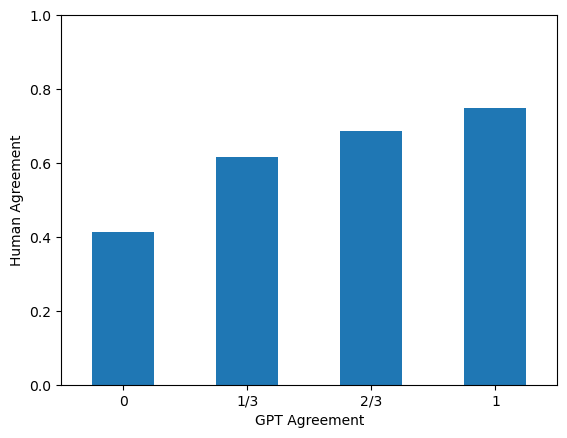

In [18]:
df_full.groupby(['gpt_nta_agreement'])['comments_nta_agreement'].mean().plot(kind='bar')
plt.gca().set_xticklabels(['0', '1/3', '2/3', '1'], rotation=0)
plt.gca().set_xlabel('GPT Agreement')
plt.gca().set_ylabel('Human Agreement')
plt.gca().set_ylim([0, 1])

In [43]:
ruff = comments.groupby('id').apply(lambda x: (x['comment_label'] == 'NTA').mean())

In [44]:
ruff

id
10009do    0.653846
1000cb3    0.255319
1000em9    0.750000
1000eye    0.620000
1000hem    0.125000
             ...   
zzz41t     0.000000
zzzhq4     0.000000
zzzmo4     0.761905
zzzo2z     0.888889
zzzy11     0.272727
Length: 12563, dtype: float64

In [42]:
comments['comment_label']

0         YTA
1         YTA
2         YTA
3         YTA
4         YTA
         ... 
531808    NaN
531809    NaN
531810    NTA
531811    NaN
531812    YTA
Name: comment_label, Length: 531813, dtype: object